In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

from scipy.optimize import curve_fit
from tqdm.auto import trange
from tqdm import tqdm
import Metropolis_Algorithm as MA

import importlib

importlib.reload(MA)

# Setting Constants
x_0 = 0
y_0 = 0
t_i = 0
t_f = 8

mass = 1
steps = 130  # Reduced from 800 - fewer points to update
numb_paths = 1000

times = np.linspace(t_i, t_f, steps)
dt = times[1] - times[0]

In [9]:
# Potential
def x_potential(x):
    return 1/2 * x**2

def y_potential(x):
    return 1000 * x**4

def ho_analytic_pdf(x):
    return (1 / np.sqrt(np.pi)) * np.exp(-x**2)

def residual_calculator(x_values, model, model_parameters, y_values, y_errors):
    theoretical_values = model(x_values, *model_parameters)
    residuals = (y_values - theoretical_values)/y_errors
    return residuals

In [10]:
# Initialize paths (Brownian bridge from 0 to 0)
paths_x = np.array([
    MA.Pos_Gen(0.0, 0.0, steps, dt)
    for _ in range(numb_paths)
])

C = 1.8437008005694266
mid = paths_x.shape[1] // 2
thin = 10
sigma_prop = C * np.sqrt(dt)

# Thermalization
print("Thermalizing...")
for sweep in trange(500, desc="Thermalising", mininterval=0):
    acceptances, endpoint_accept = MA.metropolis_sweep_vectorised(
        paths_x, times, mass, x_potential, sigma_prop
    )

    if sweep % 100 == 0:
        tqdm.write(f"Endpoint acceptance ≈ {endpoint_accept:.3f}")

# Sampling
print("\nSampling...")
samples_x = []

for k in trange(5000, desc="Sampling", mininterval=0):
    acceptances, endpoint_accept = MA.metropolis_sweep_vectorised(
        paths_x, times, mass, x_potential, sigma_prop
    )

    if k % 100 == 0:
        tqdm.write(f"Endpoint acceptance ≈ {endpoint_accept:.3f}")

    if k % thin == 0:
        samples_x.append(paths_x[:, -1].copy())

samples_x = np.concatenate(samples_x)

# Compute PDF
x_bins = np.linspace(-2, 2, 201)
pdf_unnormalised_x, bin_edges_x = np.histogram(samples_x, bins=x_bins)

x_centres = 0.5 * (bin_edges_x[1:] + bin_edges_x[:-1])
dx = np.diff(x_bins)[0]

pdf_x = pdf_unnormalised_x / np.sum(pdf_unnormalised_x * dx)

# Analytic PDF
phi_sq_analytic_x = (1 / np.sqrt(np.pi)) * np.exp(-x_centres ** 2)
phi_sq_analytic_x /= np.sum(phi_sq_analytic_x * dx)

# Statistics
mean_square_x = np.mean(samples_x ** 2)
rms = np.sqrt(mean_square_x)
std = np.std(samples_x)


Thermalizing...


Thermalising:  39%|███▉      | 197/500 [00:00<00:00, 1118.32it/s]

Endpoint acceptance ≈ 0.509
Endpoint acceptance ≈ 0.517


Thermalising:  80%|████████  | 400/500 [00:00<00:00, 1087.18it/s]

Endpoint acceptance ≈ 0.515
Endpoint acceptance ≈ 0.518


Thermalising: 100%|██████████| 500/500 [00:00<00:00, 1004.58it/s]


Endpoint acceptance ≈ 0.544

Sampling...


Sampling:   2%|▏         | 109/5000 [00:00<00:04, 1085.50it/s]

Endpoint acceptance ≈ 0.528
Endpoint acceptance ≈ 0.560


Sampling:   4%|▍         | 212/5000 [00:00<00:04, 986.96it/s] 

Endpoint acceptance ≈ 0.531


Sampling:   8%|▊         | 402/5000 [00:00<00:04, 933.95it/s] 

Endpoint acceptance ≈ 0.522
Endpoint acceptance ≈ 0.535


Sampling:  10%|█         | 513/5000 [00:00<00:04, 1084.61it/s]

Endpoint acceptance ≈ 0.525


Sampling:  14%|█▍        | 720/5000 [00:00<00:03, 1082.05it/s]

Endpoint acceptance ≈ 0.516
Endpoint acceptance ≈ 0.527


Sampling:  16%|█▋        | 818/5000 [00:00<00:03, 1094.44it/s]

Endpoint acceptance ≈ 0.499


Sampling:  20%|██        | 1008/5000 [00:00<00:03, 1056.81it/s]

Endpoint acceptance ≈ 0.514
Endpoint acceptance ≈ 0.533


Sampling:  22%|██▏       | 1115/5000 [00:01<00:03, 1026.67it/s]

Endpoint acceptance ≈ 0.528


Sampling:  26%|██▌       | 1309/5000 [00:01<00:03, 1067.34it/s]

Endpoint acceptance ≈ 0.533
Endpoint acceptance ≈ 0.533


Sampling:  28%|██▊       | 1417/5000 [00:01<00:03, 1178.01it/s]

Endpoint acceptance ≈ 0.528


Sampling:  32%|███▏      | 1614/5000 [00:01<00:03, 898.40it/s] 

Endpoint acceptance ≈ 0.515
Endpoint acceptance ≈ 0.521


Sampling:  34%|███▍      | 1713/5000 [00:01<00:03, 1095.66it/s]

Endpoint acceptance ≈ 0.506


Sampling:  38%|███▊      | 1923/5000 [00:01<00:02, 1147.09it/s]

Endpoint acceptance ≈ 0.509
Endpoint acceptance ≈ 0.536


Sampling:  40%|████      | 2022/5000 [00:01<00:02, 1012.91it/s]

Endpoint acceptance ≈ 0.545


Sampling:  44%|████▍     | 2220/5000 [00:02<00:02, 1135.86it/s]

Endpoint acceptance ≈ 0.481
Endpoint acceptance ≈ 0.499


Sampling:  46%|████▋     | 2323/5000 [00:02<00:02, 1144.25it/s]

Endpoint acceptance ≈ 0.529


Sampling:  50%|█████     | 2525/5000 [00:02<00:02, 1215.42it/s]

Endpoint acceptance ≈ 0.515
Endpoint acceptance ≈ 0.513


Sampling:  52%|█████▏    | 2613/5000 [00:02<00:01, 1293.44it/s]

Endpoint acceptance ≈ 0.532


Sampling:  56%|█████▋    | 2814/5000 [00:02<00:02, 1065.61it/s]

Endpoint acceptance ≈ 0.516
Endpoint acceptance ≈ 0.516


Sampling:  58%|█████▊    | 2914/5000 [00:02<00:01, 1109.74it/s]

Endpoint acceptance ≈ 0.544


Sampling:  62%|██████▏   | 3122/5000 [00:02<00:01, 1136.81it/s]

Endpoint acceptance ≈ 0.524
Endpoint acceptance ≈ 0.509


Sampling:  65%|██████▍   | 3227/5000 [00:02<00:01, 1156.55it/s]

Endpoint acceptance ≈ 0.517


Sampling:  68%|██████▊   | 3422/5000 [00:03<00:01, 1262.50it/s]

Endpoint acceptance ≈ 0.532
Endpoint acceptance ≈ 0.549


Sampling:  70%|███████   | 3521/5000 [00:03<00:01, 1109.55it/s]

Endpoint acceptance ≈ 0.518


Sampling:  74%|███████▍  | 3718/5000 [00:03<00:01, 1016.10it/s]

Endpoint acceptance ≈ 0.545
Endpoint acceptance ≈ 0.494


Sampling:  88%|████████▊ | 4418/5000 [00:04<00:00, 1149.06it/s]

Endpoint acceptance ≈ 0.530


Sampling:  92%|█████████▏| 4617/5000 [00:04<00:00, 1113.53it/s]

Endpoint acceptance ≈ 0.538
Endpoint acceptance ≈ 0.510


Sampling:  94%|█████████▍| 4719/5000 [00:04<00:00, 1092.49it/s]

Endpoint acceptance ≈ 0.543



------ Results ------
Numerical PDF area: 1.00000
Analytic PDF area: 1.00000
Standard deviation: 0.7681 (expected ≈ 0.707)
Root mean square: 0.7684 (expected ≈ 0.707)


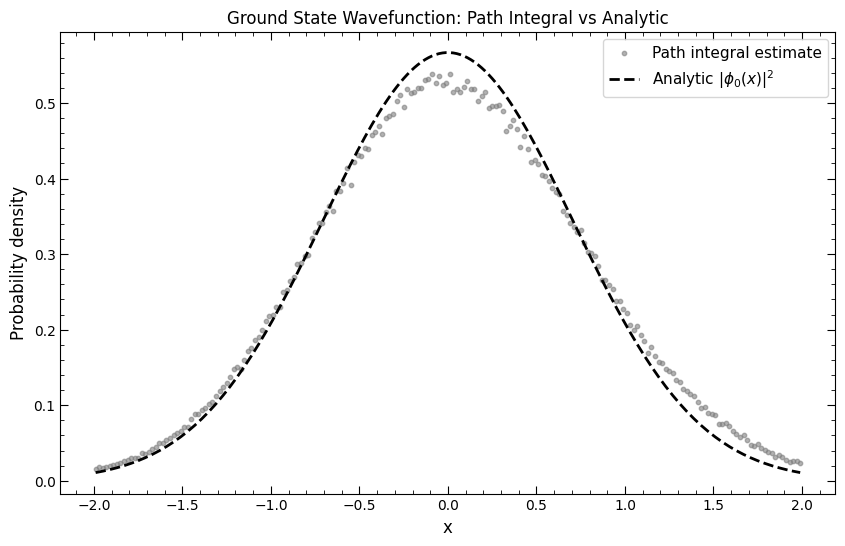

In [11]:
pc_savepath_metropolis_groundstate = r"C:\Users\User\Documents\Durham Work\Year 3\CompPhys\metropolis_groundstate.svg"
laptop_savepath_metropolis_groundstate = r"C:\Users\sebas\Documents\Durham Work\Year 3\Comp Phys\metropolis_groundstate.svg"

print("\n------ Results ------")
print(f"Numerical PDF area: {np.sum(pdf_x * dx):.5f}")
print(f"Analytic PDF area: {np.sum(phi_sq_analytic_x * dx):.5f}")
print(f"Standard deviation: {std:.4f} (expected ≈ 0.707)")
print(f"Root mean square: {rms:.4f} (expected ≈ 0.707)")

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(x_centres, pdf_x, label='Path integral estimate', s=10, alpha=0.6, color='grey')
plt.plot(x_centres, phi_sq_analytic_x, 'black', linestyle='--', linewidth=2, label=r'Analytic $|\phi_0(x)|^2$')
plt.xlabel('x', fontsize=12)
plt.ylabel('Probability density', fontsize=12)
plt.legend(fontsize=11)
plt.minorticks_on()
plt.tick_params(which = 'major', length = 6, bottom = True, top = True, left = True, right = True, direction = 'in')
plt.tick_params(which = 'minor', length = 3, bottom = True, top = True, left = True, right = True, direction = 'in')
plt.title('Ground State Wavefunction: Path Integral vs Analytic')

plt.savefig(laptop_savepath_metropolis_groundstate, bbox_inches='tight')
plt.show()